# NAO plot
This notebook is for plotting:

- **Figure 9**: Correlation coefficients between the NAO phase and thetotal cumulative anomalies
- **Supplementary Figure 11**: Correlation between the mean NAO phase and energy production

/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

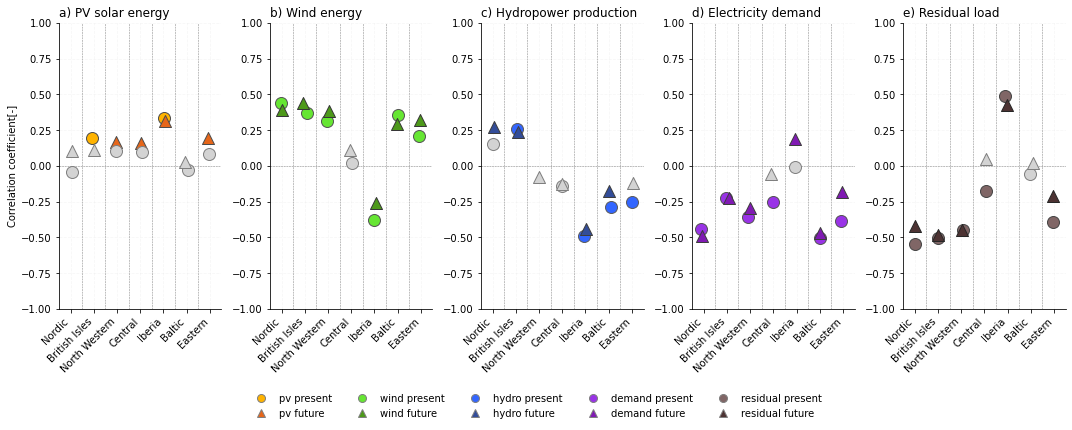

In [3]:
# ---------------------------
# Import Required Libraries
# ---------------------------
import xarray as xr
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from matplotlib.lines import Line2D

# ---------------------------
# Define Constants
# ---------------------------
colors = [
    [(1.0, 0.7, 0.0), (0.9, 0.4, 0.1)],
    [(0.4, 0.9, 0.2), (0.3, 0.6, 0.1)],
    [(0.2, 0.4, 1), (0.2, 0.3, 0.6)],
    [(0.6, 0.2, 0.9), (0.5, 0.1, 0.7)],
    [(0.5, 0.4, 0.4), (0.3, 0.2, 0.2)],
]
metrics = ['pv', 'wind', 'hydro', 'demand', 'residual']
titels = ['PV solar energy', 'Wind energy', 'Hydropower production', 'Electricity demand', 'Residual load']
regions = ["Nordic", "British Isles", "North Western", "Central", "Iberia", "Baltic", "Eastern"]
colors_dict = dict(zip(metrics, colors))

# ---------------------------
# Define Functions
# ---------------------------

def compute_summed_productions(ds):
    """
    Add summed energy production variables to the dataset.
    """
    ds['wind'] = ds['wind_onshore'] + ds['wind_offshore']
    ds['hydro'] = ds['ror'] + ds['Eout']
    ds['pv'] = ds['pv_util']
    return ds


def compute_anom(ds, timestep):
    """
    Compute anomalies by subtracting the mean for each timestep.
    """
    groups = ds.stack(z=('runs', 'time')).groupby(timestep)
    means = groups.mean()
    ds_anom = groups - means
    return ds_anom.unstack()



# def compute_anom_ratio(ds, timestep):
#     """
#     Compute anomalies by subtracting the mean for each timestep.
#     """
#     groups = ds.stack(z=('runs', 'time')).groupby(timestep)
#     means = groups.mean()
#     ds_anom = groups - means
    
#     ds_anom_ratio = ds_anom.groupby(timestep)/means
#     return ds_anom_ratio.unstack()

# Function to group by year, sum, and compute the mean over 'runs' and 'year'
def compute_decadal_mean(ds):
    # Group by year and sum the values for each year
    decadal_values = ds.sum(dim='time')
    return decadal_values.mean(dim='runs')

# Function to normalize the anomaly dataset over the decadal means
def normalize_dataset(ds_anom, decadal_mean):
    return ds_anom / decadal_mean

# Function to compute the cumulative sum and select the last time step (end of decade)
def compute_end_of_decade_cumsum(normalized_ds):
    # Compute the cumulative sum over the 'time' dimension
    cumsum_df = normalized_ds.cumsum(dim='time')
    
    # Select the last time step in the cumulative sum (end of the decade)
    end_of_decade_df = cumsum_df.isel(time=-1)
    
    # Select only the relevant columns
    selected_columns_df = end_of_decade_df[['pv', 'wind', 'hydro', 'demand', 'residual']]
    
    # Convert the result to a pandas DataFrame
    return selected_columns_df



# Main function that combines the steps
def process_end_of_decade(ds_anom, ds_regions):
    # Step 1: Compute decadal mean
    decadal_values_pd = compute_decadal_mean(ds_regions)
    
    # Step 2: Normalize the dataset over yearly means
    normalized_pd = normalize_dataset(ds_anom, decadal_values_pd)
    
    # Step 3: Compute the cumulative sum and select the last time step (end of the decade)
    normalized_df_end_of_decade = compute_end_of_decade_cumsum(normalized_pd)
    
    return normalized_df_end_of_decade


def load_and_process_energy_data2(file_pattern, metrics, anomaly_function, timestep='time.dayofyear', ratio=True):
    """
    Load regional energy production data, compute summed productions, calculate anomalies
    (using a specified anomaly function), and aggregate by month.

    Parameters:
        file_pattern (str): The file path pattern to match NetCDF files.
        metrics (list): List of energy metrics to extract and compute.
        anomaly_function (function): Function to compute anomalies (e.g., compute_anom or compute_anom_ratio).
        timestep (str): The grouping timestep for anomaly calculation (default: 'time.dayofyear').

    Returns:
        xr.DataArray: Monthly aggregated anomalies for each region and each metric.
    """
    # Load regional energy production data
    region_files = glob.glob(file_pattern)
    ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
    data = ds_regions.compute()
    
    # Compute summed productions
    data = compute_summed_productions(data)
    data = data[metrics]

    # Calculate anomalies using the provided anomaly function
    data_anom = anomaly_function(data, timestep)

    data_anom_norm = process_end_of_decade(data_anom, data)

    return data_anom_norm.fillna(0)


def load_and_process_energy_data(file_pattern, metrics, anomaly_function, timestep='time.dayofyear', ratio=True):
    """
    Load regional energy production data, compute summed productions, calculate anomalies
    (using a specified anomaly function), and aggregate by month.

    Parameters:
        file_pattern (str): The file path pattern to match NetCDF files.
        metrics (list): List of energy metrics to extract and compute.
        anomaly_function (function): Function to compute anomalies (e.g., compute_anom or compute_anom_ratio).
        timestep (str): The grouping timestep for anomaly calculation (default: 'time.dayofyear').

    Returns:
        xr.DataArray: Monthly aggregated anomalies for each region and each metric.
    """
    # Load regional energy production data
    region_files = glob.glob(file_pattern)
    ds_regions = xr.open_mfdataset(region_files, concat_dim='region')
    data = ds_regions.compute()
    
    # Compute summed productions
    data = compute_summed_productions(data)
    data = data[metrics]

    # Calculate anomalies using the provided anomaly function
    data_anom = anomaly_function(data, timestep)

    # Aggregate anomalies by month
#     data_anom_m = data_anom.resample(time='1M').mean()

    # Sum over all months for each metric
    data_anom_m_total = data_anom.sum(dim=['time'])

    if ratio:
        data_anom_m_total = data_anom_m_total/data.sum(dim=['time', 'runs'])
    return data_anom_m_total.fillna(0)



def process_nao_index(file_pattern):
    """
    Load sea level pressure data, select winter months (DJF), compute the NAO index, 
    and calculate the average NAO winter phase per run.
    """
    file_paths = sorted(glob.glob(file_pattern))
    ds = xr.open_mfdataset(file_paths, combine='nested', concat_dim='runs')
    ds['runs'] = np.arange(len(file_paths))  # Assign unique IDs for each run

    # Select winter months
    ds = ds.assign_coords(season_year=(ds['time'].dt.year + (ds['time'].dt.month == 12)))
    ds_winter = ds.sel(time=ds.time.dt.month.isin([12, 1, 2]))

    # Compute NAO index
    psl = ds_winter['psl'].assign_coords(lon=((ds_winter['psl'].lon + 360) % 360)).sortby('lon')
    psl_iceland = psl.sel(lat=slice(60, 70), lon=slice(-30 % 360, -10 % 360)).mean(dim=['lat', 'lon'])
    psl_azores = psl.sel(lat=slice(35, 45), lon=slice(-20 % 360, -10 % 360)).mean(dim=['lat', 'lon'])
    nao_index = (psl_azores - psl_azores.mean(dim='runs')) / psl_azores.std(dim='runs') - (
        psl_iceland - psl_iceland.mean(dim='runs')
    ) / psl_iceland.std(dim='runs')

    # Compute average NAO winter phase
    nao_avg_per_run = nao_index.mean(dim='time')
    return nao_avg_per_run.to_dataframe(name='nao_winter_avg').reset_index()


def compute_correlations(scenario, anom_m_total, nao_avg_df):
    """
    Compute Pearson correlations between NAO and energy anomalies.
    """
    results = []
    for region in regions:
        energy_data = anom_m_total.sel(region=region).to_dataframe().reset_index()[metrics].T
        energy_data.loc['nao_winter_avg', :] = nao_avg_df['nao_winter_avg'].values.T
        energy_data = energy_data.T

        for var in metrics:
            r, p = pearsonr(energy_data['nao_winter_avg'], energy_data[var])
            results.append({
                'region': region,
                'technology': var,
                'correlation': r,
                'p_value': p,
                'scenario': scenario
            })
    return results

# ---------------------------
# Load Data and Compute Metrics
# ---------------------------m
anom_m_total_present = load_and_process_energy_data2(
    '/nobackup/users/most/output/PD_project3/agg_production/per_region/*.nc',
    metrics,
    compute_anom, ratio=True
)


anom_m_total_present
anom_m_total_future = load_and_process_energy_data2(
    '/nobackup/users/most/output/LENTIS_2023_FU/agg_production/per_region/*FU.nc', 
    metrics,
    compute_anom, ratio=True
)


nao_avg_df_present = process_nao_index('/nobackup/users/most/LENTIS/present/month/psl_m_global/*.nc')
nao_avg_df_future = process_nao_index('/nobackup/users/most/LENTIS/future/month/psl_m/*.nc')

correlation_data = compute_correlations('present', anom_m_total_present, nao_avg_df_present) + \
                   compute_correlations('future', anom_m_total_future, nao_avg_df_future)

correlation_df = pd.DataFrame(correlation_data)
correlation_df['tech_scenario'] = correlation_df['technology'] + ' ' + correlation_df['scenario']


# Define a custom palette for each variable
palette = {f'{var} {scenario}': colors_dict[var][j]
           for var in metrics for j, scenario in enumerate(['present', 'future'])}

# Define markers for scenarios
scenario_markers = {'present': 'o', 'future': '^'}  # 'o' for open circle, '^' for triangle

# Get unique technologies for iteration
technologies = metrics

# Create a figure with subplots, one for each technology
fig, axes = plt.subplots(1, len(technologies), figsize=(len(technologies) * 3, 6), sharex=True)

# Initialize a dictionary for legend entries
legend_entries = {}

# Iterate over each technology and create a plot for it
for i, tech in enumerate(technologies):
    # Filter data for the current technology
    tech_data = correlation_df[correlation_df['technology'] == tech]

    # Create a dataset for non-significant values
    non_significant_data = tech_data.copy()
    non_significant_data.loc[tech_data['p_value'] < 0.05, 'correlation'] = np.nan

    # Remove non-significant values from main data
    tech_data.loc[tech_data['p_value'] >= 0.05, 'correlation'] = np.nan

    # Plot the strip plot for significant values
    for scenario in ['present', 'future']:
        sns.stripplot(
            data=tech_data[tech_data['scenario'] == scenario],
            x='region', y='correlation', hue='tech_scenario', palette=palette,
            dodge=False, marker=scenario_markers[scenario], s=12, ax=axes[i],
            edgecolor="gray", linewidth=1
        )

    # Add grid lines between ticks
    x_ticks = axes[i].get_xticks()
    x_grid_positions = x_ticks[:-1] + 0.5  # Shift grid lines between ticks
    for grid_pos in x_grid_positions:
        axes[i].axvline(grid_pos, color='grey', linestyle='--', linewidth=0.5)

    # Rotate x-axis labels
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

    # Overlay non-significant values as light grey
    for scenario in ['present', 'future']:
        sns.stripplot(
            data=non_significant_data[non_significant_data['scenario'] == scenario],
            x='region', y='correlation', color='lightgrey',
            dodge=False, marker=scenario_markers[scenario], s=12, ax=axes[i],
            edgecolor="gray", linewidth=1
        )

    # Customize subplot appearance
    # Add subplot index as a letter prefix to the title
    axes[i].set_title(f"{chr(97 + i)}) {titels[i]}", fontsize=12, loc='left', x=0.0)  # 'chr(97 + i)' gives 'a', 'b', 'c', etc.
    axes[i].axhline(0, color='grey', linestyle='--', linewidth=0.5)  # Horizontal line at zero
    axes[i].grid(True, linestyle='--', alpha=0.1)  # Add grid
    axes[i].spines['top'].set_visible(False)  # Remove top border
    axes[i].spines['right'].set_visible(False)  # Remove right border
    axes[i].set_ylabel('')
    axes[i].legend_.remove()
    axes[i].set_xlabel("")
    axes[i].set_ylim([-1, 1])

axes[0].set_ylabel('Correlation coefficient[-]')

# Define legend entries
legend_entries = [
    Line2D([0], [0], color=palette[f'{var} {scenario}'], marker=scenario_markers[scenario],
           markersize=8, linestyle='None', label=f'{var} {scenario}', markeredgecolor="gray", markeredgewidth=1)
    for var in metrics for scenario in ['present', 'future']
]

# Add a common legend at the bottom of the figure
fig.legend(
    handles=legend_entries, loc='upper center', ncol=5, frameon=False, fontsize=10,
    bbox_to_anchor=(0.5, 0.05)
)

# Adjust layout and save the plot
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig('/usr/people/most/03_project3/img/NAO_correlation_per_run.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


/usr/people/most/miniconda3/envs/clever/lib/python3.9/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


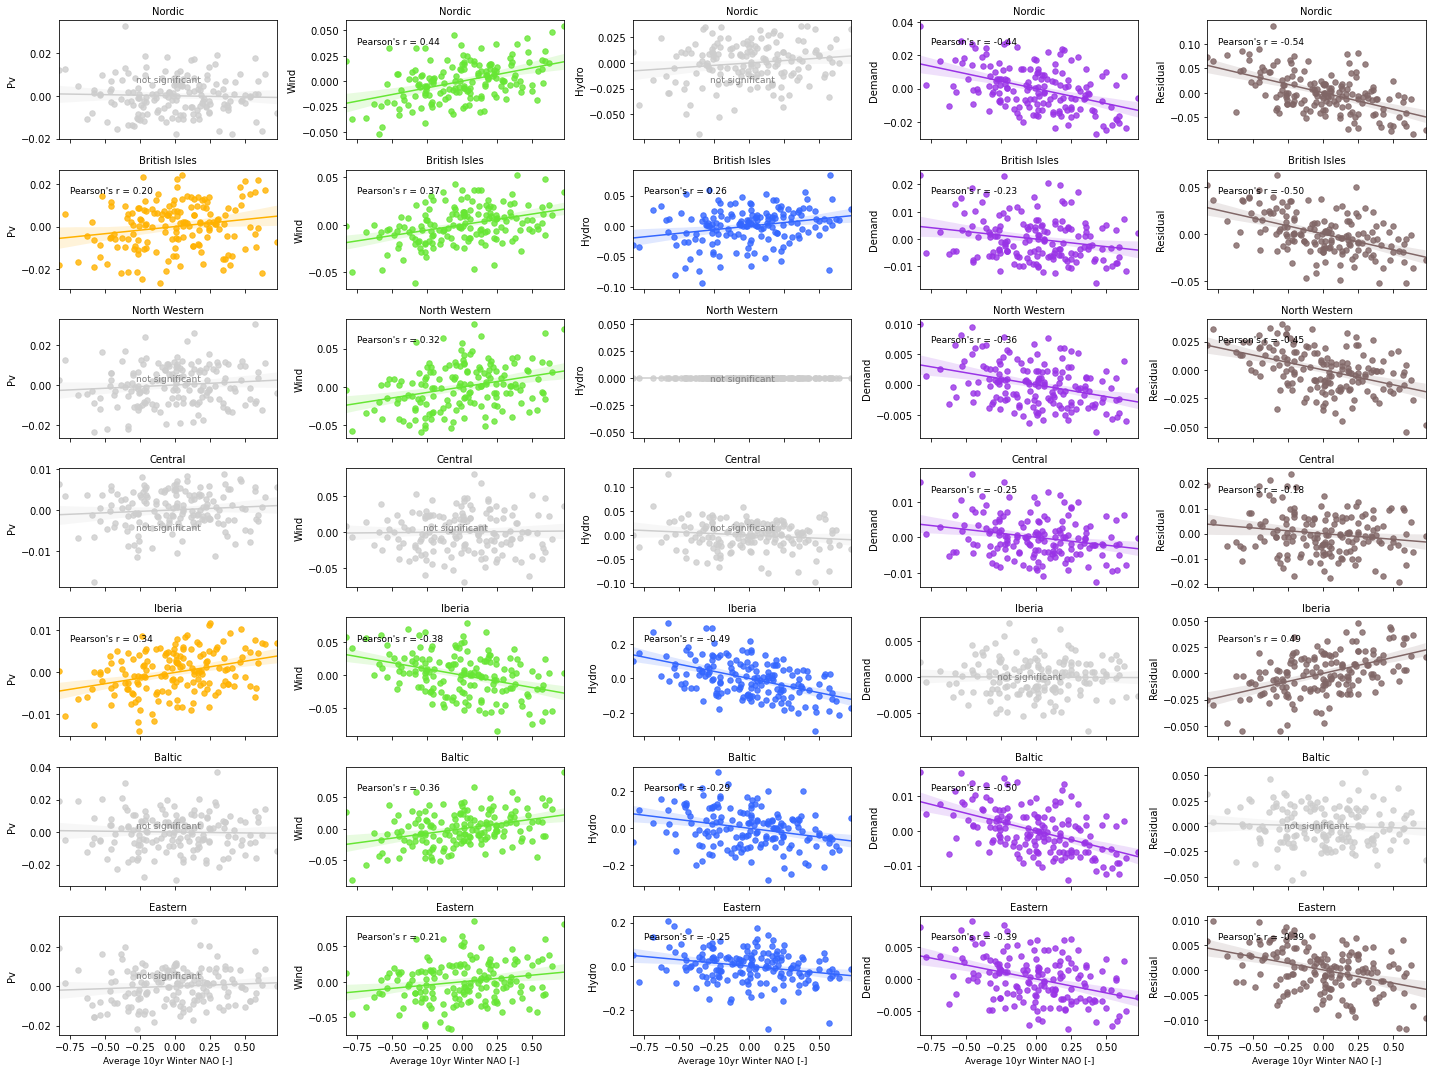

In [9]:
# ---------------------------
# Generate Subplots for Correlations by Region and Metric
# ---------------------------
fig, axs = plt.subplots(len(regions), len(metrics), figsize=(20, 15), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, region in enumerate(regions):
    # Extract energy anomalies for the specific region
    energy_end_of_runs = anom_m_total_present.sel(region=region).to_dataframe().reset_index()[metrics].T
    energy_nao_df = energy_end_of_runs.copy()
    energy_nao_df.loc['nao_winter_avg', :] = nao_avg_df_present['nao_winter_avg'].values.T
    energy_nao_df = energy_nao_df.T  # Transpose to align with DataFrame structure

    # Iterate through each metric to create subplots
    for j, var in enumerate(metrics):
        # Compute Pearson correlation
        r, p = pearsonr(energy_nao_df['nao_winter_avg'], energy_nao_df[var])

        # Plot significant correlations in color, others in grey
        if p < 0.05:
            sns.regplot(
                x='nao_winter_avg', y=var, data=energy_nao_df,
                color=colors_dict[var][0], ax=axs[i, j],
                scatter_kws={"s": 30}, line_kws={"linewidth": 1.5}
            )
            axs[i, j].text(
                0.05, 0.8, f"Pearson's r = {r:.2f}",
                transform=axs[i, j].transAxes, fontsize=9
            )
        else:
            sns.regplot(
                x='nao_winter_avg', y=var, data=energy_nao_df,
                color="#CDCDCD", ax=axs[i, j],
                scatter_kws={"s": 30}, line_kws={"linewidth": 1.5}
            )
            axs[i, j].text(
                0.5, 0.5, "not significant",
                ha='center', va='center', fontsize=9, color='gray',
                transform=axs[i, j].transAxes
            )
   
        # Customize subplot labels
        axs[i, j].set_title(region, fontsize=10)
        axs[i, j].set_xlabel('Average 10yr Winter NAO [-]' if i == len(regions) - 1 else '', fontsize=9)
        axs[i, j].set_ylabel(var.capitalize(), fontsize=10)

# Adjust layout and save the figure
fig.tight_layout()
plt.savefig("/usr/people/most/03_project3/img/pd_pearsoncorr_NAO_per_run.jpg", dpi=300, bbox_inches='tight')
plt.show()


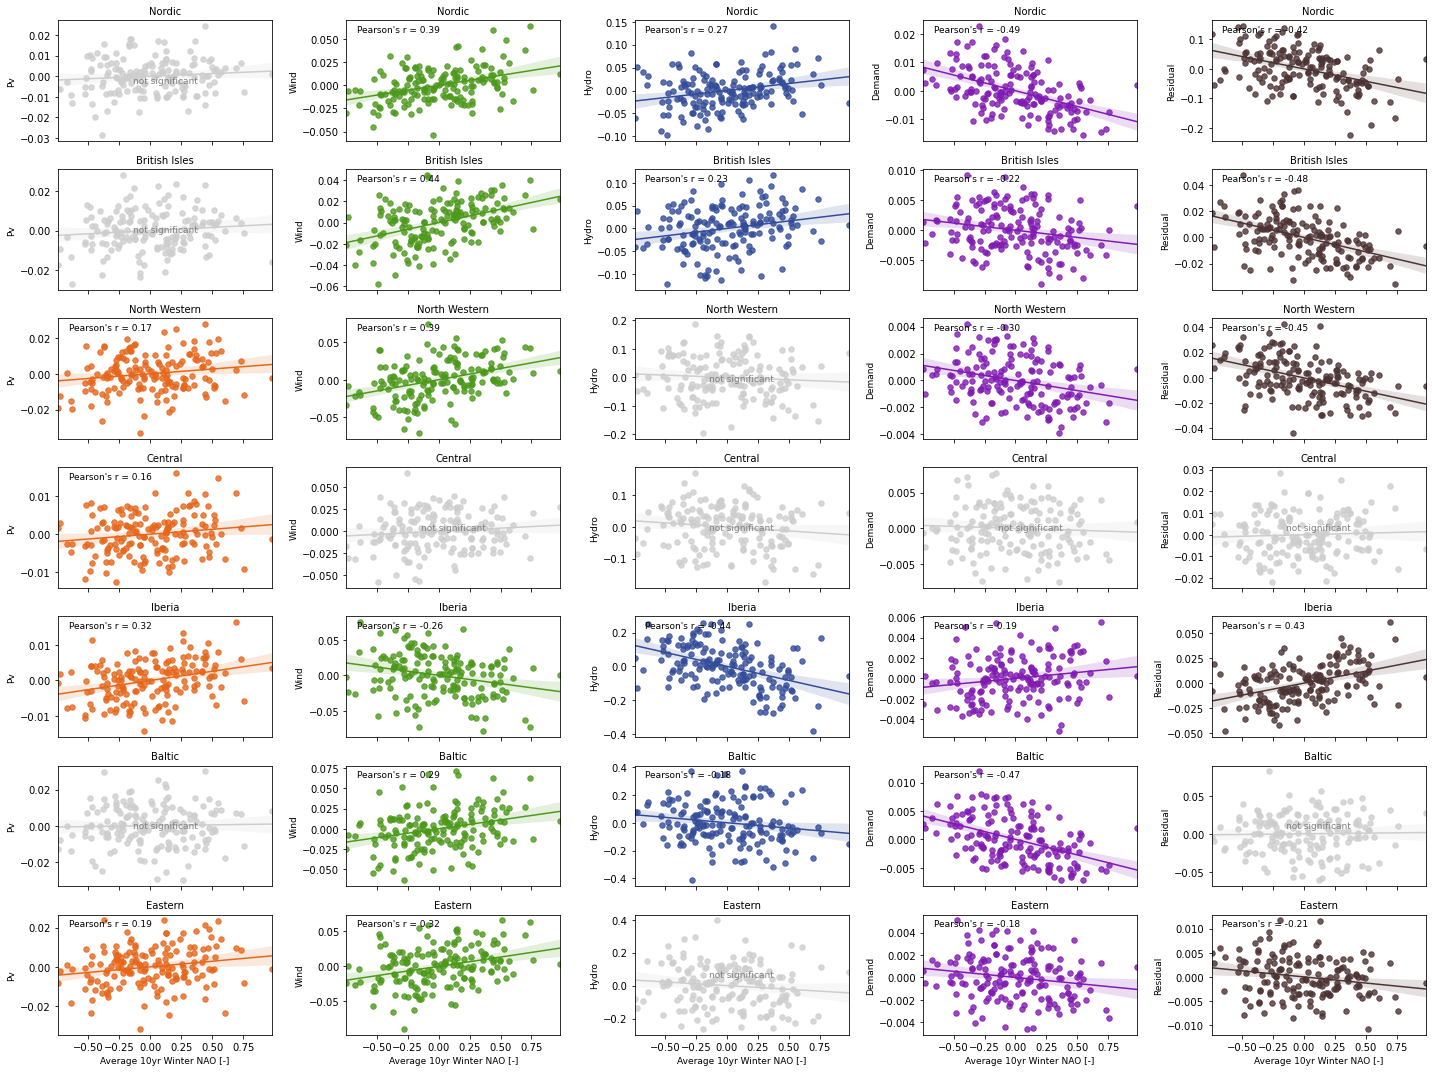

In [11]:
# ---------------------------
# Generate Subplots for Correlations by Region and Metric
# ---------------------------
fig, axs = plt.subplots(len(regions), len(metrics), figsize=(20, 15), sharex=True, sharey=False)
fig.subplots_adjust(hspace=0.4, wspace=0.3)

for i, region in enumerate(regions):
    # Extract energy anomalies for the specific region
    energy_end_of_runs = anom_m_total_future.sel(region=region).to_dataframe().reset_index()[metrics].T
    energy_nao_df = energy_end_of_runs.copy()
    energy_nao_df.loc['nao_winter_avg', :] = nao_avg_df_future['nao_winter_avg'].values.T
    energy_nao_df = energy_nao_df.T  # Transpose to align with DataFrame structure

    # Iterate through each metric to create subplots
    for j, var in enumerate(metrics):
        # Compute Pearson correlation
        r, p = pearsonr(energy_nao_df['nao_winter_avg'], energy_nao_df[var])

        # Plot significant correlations in color, others in grey
        if p < 0.05:
            sns.regplot(
                x='nao_winter_avg', y=var, data=energy_nao_df,
                color=colors_dict[var][1], ax=axs[i, j],
                scatter_kws={"s": 30}, line_kws={"linewidth": 1.5}
            )
            axs[i, j].text(
                0.05, 0.9, f"Pearson's r = {r:.2f}",
                transform=axs[i, j].transAxes, fontsize=9
            )
        else:
            sns.regplot(
                x='nao_winter_avg', y=var, data=energy_nao_df,
                color="#CDCDCD", ax=axs[i, j],
                scatter_kws={"s": 30}, line_kws={"linewidth": 1.5}
            )
            axs[i, j].text(
                0.5, 0.5, "not significant",
                ha='center', va='center', fontsize=9, color='gray',
                transform=axs[i, j].transAxes
            )

        # Customize subplot labels
        axs[i, j].set_title(region, fontsize=10)
        axs[i, j].set_xlabel('Average 10yr Winter NAO [-]' if i == len(regions) - 1 else '', fontsize=9)
        axs[i, j].set_ylabel(var.capitalize(), fontsize=9)

# Adjust layout and save the figure
fig.tight_layout()
plt.savefig("/usr/people/most/03_project3/img/fu_pearsoncorr_NAO_per_run.jpg", dpi=300, bbox_inches='tight')
plt.show()
